<a href="https://colab.research.google.com/github/tvpian/NERF_Series/blob/main/NERF_Series_01_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
def simulator(x, t=3):

    x0, v0 = x[:2], x[2:]

    a = torch.tensor([0, -9.81])
    v = v0 + a * t
    x = x0 + v0 * t + .5 * a * t**2

    return torch.cat((x, v))

In [3]:
# Replicating a scenario where an object is thrown from a initial position with
# a non-zero velocity

x0 = torch.tensor([0.0, 0.0])
v0 = torch.tensor([10.0, 10.0])
x = torch.cat((x0, v0))
b = simulator(x, t=3)

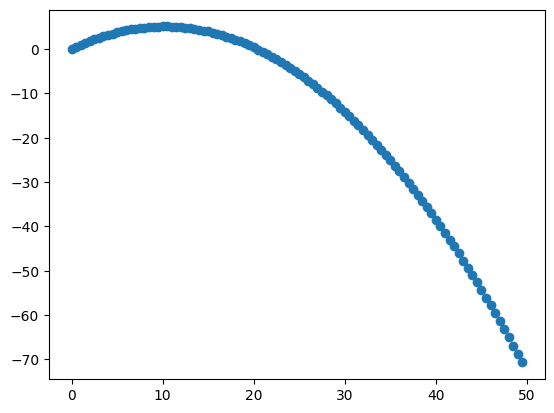

In [4]:
all_pos = []
for t in range(100):
    y = simulator(x, t=t/20)
    all_pos.append(y[:2])
all_pos = np.array(all_pos)
plt.scatter(all_pos[:, 0], all_pos[:, 1])
plt.show()

\begin{equation}
\arg \min_x\|A(x) - b\|_2^2
\end{equation}
x -  It is the NERF model we wish to optimize

A - the model that can simulate how the pictures taken from a camera or phone would look like.

b - Actual image taken by a camera or phone



Case 1

In [5]:
x = torch.tensor([0.0, 0.0, 0.0, 0.0], requires_grad=True)
optimizer = torch.optim.SGD({x}, lr=0.01)
training_loss = []

for epoch in range(200):
 Ax = simulator(x, t = 3)
 loss = ((Ax - b)**2).mean()
 optimizer.zero_grad()
 loss.backward()
 optimizer.step()
 training_loss.append(loss.item())
#  print(loss.item())

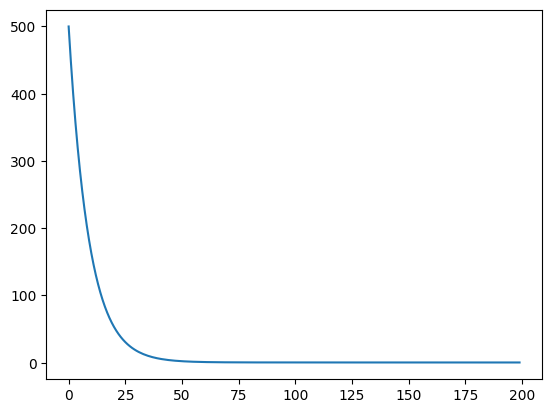

In [6]:
plt.plot(training_loss)
plt.show()

# Camera Model

In [7]:
import numpy as np

In [8]:
H = 400
W = 400
f = 1200

In [9]:
# Defing the camera model

rays_o = np.zeros((H, W, 3)) # Vector array to store the position of each pixel on the image plane
rays_d = np.zeros((H, W, 3)) # Vector array to store the direction of the rays intersecting each pixel

# Defining the image plane
u =  np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v) # Creating a meshgrid based on the value of u,v - This is a way to represent each pixel location with 2D coordinate system

# Representing the image plane in the camera coordinate frame
dirs = np.stack((u-W/2, -(v-H/2), -np.ones_like(u) * f), axis=-1) # Representing the image plane wrt to the camera coordinate frame

rays_d = dirs/ np.linalg.norm(dirs, axis=-1, keepdims=True) # Normalizing the direction of the rays wrt to last axis(dividing all elements by f)

## By doing the above we are simulating the scenario where the rays are coming from the camera optical center to the objects

rays_d = rays_d.reshape(-1, 3)
rays_o = rays_o.reshape(-1, 3)

In [10]:
u.shape, v.shape, rays_d.shape

((400, 400), (400, 400), (160000, 3))

In [11]:
dirs[0, 0], rays_d[0, 0]

(array([ -200.,   200., -1200.]), -0.16222142113076254)

In [12]:
print(u), print(v)

[[  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 ...
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]]
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [397 397 397 ... 397 397 397]
 [398 398 398 ... 398 398 398]
 [399 399 399 ... 399 399 399]]


(None, None)

In [13]:
def plot_rays(o, d, t):
  """
  Plot the rays on the image plane
  o - Starting point of the vector
  d - Direction of the vector
  t - Time
  """
  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(111, projection='3d')

  pt1 = o # Starting point of the vector
  pt2 = o + d * t  # Ending point of the vector

  for p1, p2 in zip(pt1[::100], pt2[::100]):
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]]) # Plotting the first 100 rays from the camera optical center to the image plane

  # Change the angle of view
  ax.view_init(elev=180, azim=-60)

  # Show the axis
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  plt.show()


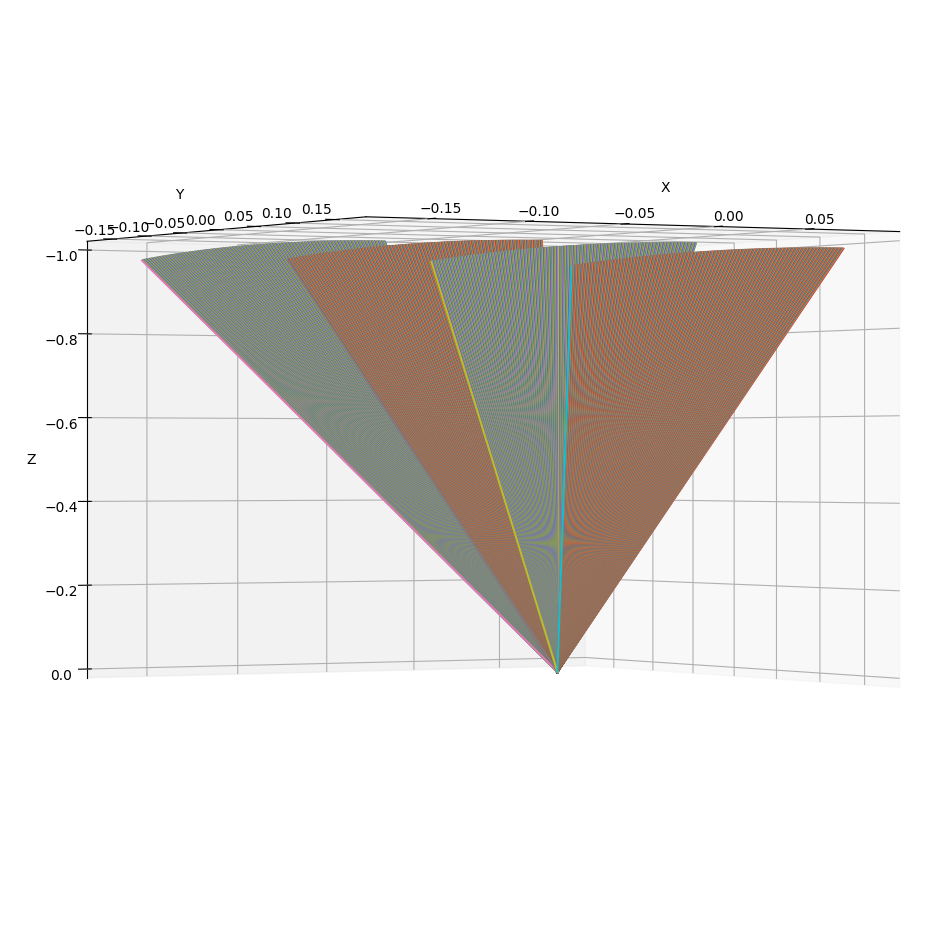

In [14]:
plot_rays(rays_o, rays_d, 1)

### 3D Rendering

In [15]:
# Creating a scene containing a sphere
class Sphere():
  def __init__(self, p, r, color):
    """
    p - Position of the sphere
    r - Radius of the sphere
    color - Color of the sphere
    """
    self.p = p
    self.r = r
    self.color = color
  def intersect(self, o, d):
    """
    Assigns which ray intersects the sphere and returns the distance and color of the intersection
    o - Starting point of the vector
    d - Direction of the vector
    """
    # Define the equation of the sphere - (x1 - x)^2 + (y1 - y)^2 + (z1 - z)^2 = r^2
    # Also can be written as (ox + t * dx - xc)^2 + (oy + t * dy - yc)^2 + (oz + t * dz - zc)^2 = r^2

    a = d[:, 0]**2 + d[:, 1]**2 + d[:, 2]**2
    b = 2 * ((d[:, 0] * (o[:, 0] - self.p[0])) + (d[:, 1] * (o[:, 1] - self.p[1])) + (d[:, 2] * (o[:, 2] - self.p[2])))
    c = (o[:,0] - self.p[0])**2 + (o[:,1] - self.p[1])**2 + (o[:,2] - self.p[2])**2 - self.r**2

    discriminant = b**2 - 4 * a * c
    # print(discriminant.shape)
    # print(np.where(discriminant > 0))
    # print(discriminant[discriminant > 0])
    colors = np.zeros((o.shape[0], 3))
    condition = discriminant >= 0
    # print(condition.shape)
    # t = (-b - np.sqrt(discriminant)) / (2 * a)
    # t = t[condition]
    colors[condition] = self.color
    # print(colors.shape)

    return colors

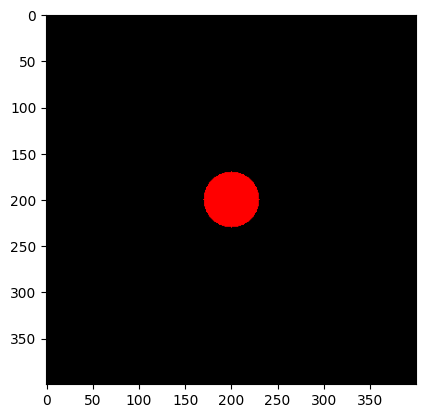

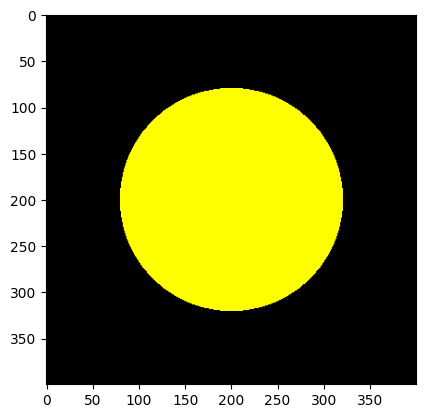

In [16]:
sphere1 = Sphere(np.array([0, 0, -1]), 0.1, np.array([1, 1, 0]))
sphere2 = Sphere(np.array([0, 0, -2]), 0.05, np.array([1, 0, 0]))
colr1 = sphere1.intersect(rays_o, rays_d)
colr2 = sphere2.intersect(rays_o, rays_d)
# Plot the colors
colr1 = colr1.reshape(H, W, 3)
colr2 = colr2.reshape(H, W, 3)
plt.imshow(colr2)
plt.show()
plt.imshow(colr1)
plt.show()

### Volume Rendering

In [17]:
# Creating a scene containing a sphere
class Sphere():
  def __init__(self, p, r, color):
    """
    p - Position of the sphere
    r - Radius of the sphere
    color - Color of the sphere
    """
    self.p = p
    self.r = r
    self.color = color
  def intersect(self, x):
    """
    Assigns the color and density of the intersection
    x - Position of the ray in the image plane [batch_size, 3]
    """
    # Check if x is inside the sphere
    condition = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 <= self.r**2
    num_rays = x.shape[0]
    colors = torch.zeros((num_rays, 3))
    density = torch.zeros((num_rays, 1))
    colors[condition] = self.color
    density[condition] = 10
    return colors, density

In [18]:
sphere1 = Sphere(np.array([0, 0, -1]), 0.1, np.array([1, 1, 0]))

In [22]:
def rendering(model, ray_o, rays_d, tn, tf, nb_bins=100, device = 'cpu'):
  """
  Simulate the rendering of a scene with a camera and target
  ray_o - Starting point of the vector
  rays_d - Direction of the vector
  tn - Starting time
  tf - Ending time
  nb_bins - Number of bins for the histogram
  """
  t = torch.linspace(tn, tf, nb_bins).to(device)
  delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))
  o = torch.tensor(rays_o).to(device)
  d = torch.tensor(rays_d).to(device)
  # The object is to obtain time based samples for each ray
  # t - [nb_bins] - [1, nb_bins, 1]
  # d - [nb_rays, 3] - [nb_rays, 1, 3]
  # x = o + d * t # [nb_rays, nb_bins, 3]
  x = o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * d.unsqueeze(1)
  print(x.shape)

  # Query color and opacity
  color, density = model.intersect(x.view(-1, 3))

  print(color.shape)
  print(density.shape)


In [20]:
s = Sphere(torch.zeros(3), 0.1, torch.tensor([1., 0., 0.]))
d = rendering(s, rays_o, rays_d, 0.8, 1.2)

torch.Size([160000, 100, 3])
torch.Size([16000000, 3])
torch.Size([16000000, 1])


In [21]:
d